In [1]:
import re
import pandas as pd
import pickle
from collections import Counter
import numpy as np
import xlsxwriter

#sample transformation
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE


#models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#evaluation
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

#sample and model tuning
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, EditedNearestNeighbours, CondensedNearestNeighbour
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin


In [2]:
#loading datasets
reuters_df = pd.read_csv('datasets\\reuters_dataset.csv', sep='\t')
faq_df = pd.read_csv('datasets\\final_FAQ_dataset.csv', header=0, sep='\t')
amazon_df = pd.read_csv('datasets\\amazon.csv', sep='\t')
newsgroups_df = pd.read_csv('datasets\\newsgroups.csv', sep='\t')

In [11]:
def plot_threshold(threshold, num_classes, val_max=500):
    '''
    function to display disbalance for different minor/major ratio
    '''
    fig, axs = plt.subplots(1, num_classes, figsize=(15, 5))
    fig.suptitle(f'disbalance = {threshold}')
    for i in range(num_classes):
        data = [i] * val_max + list(range(i+1, num_classes)) * int((val_max * threshold)) + list(range(0, i)) * int((val_max * threshold))
        axs[i].hist(data, bins=np.arange(num_classes * 2) / 2)
        axs[i].set_xticks(range(num_classes))
        axs[i].set_xlabel('Классы')
    axs[0].set_ylabel('Число объектов')


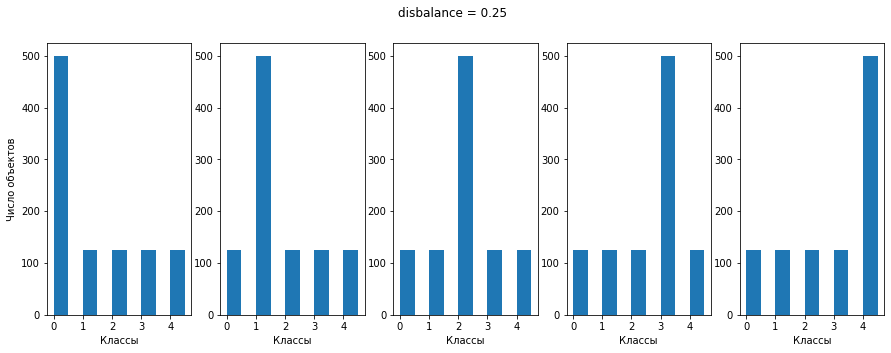

In [12]:
plot_threshold(0.25, 5)

In [12]:
# space of model for optimization
knn_space = {'n_neighbors': hp.choice('n_neighbors', range(1, 10)),
             'weights': hp.choice('weights', ['uniform', 'distance']), 
             'p': hp.choice('p', [1, 2])}
space_svm = {
      'C': hp.choice('C', np.arange(0.5,20, 0.5)),
      'kernel': hp.choice('kernel',['linear', 'poly', 'rbf']),
      'degree':hp.choice('degree',[2,3,4]),
      'probability':hp.choice('probability',[True])
      }
xgb_space={
            'max_depth': hp.choice('x_max_depth',[2,3,4,5,6]),
            'min_child_weight':hp.choice('x_min_child_weight',np.round(np.arange(0.0,0.2,0.01),5)),
            'learning_rate':hp.choice('x_learning_rate',np.round(np.arange(0.005,0.3,0.01),5)),
            'subsample':hp.choice('x_subsample',np.round(np.arange(0.1,1.0,0.05),5)),
            'colsample_bylevel':hp.choice('x_colsample_bylevel',np.round(np.arange(0.1,1.0,0.05),5)),
            'colsample_bytree':hp.choice('x_colsample_bytree',np.round(np.arange(0.1,1.0,0.05),5)),
            'n_estimators':hp.choice('x_n_estimators',np.arange(100, 300, 50))
            }
log_space={'C': hp.choice('x_C',[5, 10, 20, 30, 35]),
       'solver':  hp.choice('solver',['newton-cg', 'lbfgs', 'liblinear','sag','saga']),
       'tol': hp.loguniform('x_tol',-13,-1),
          'max_iter': hp.choice('iter', [700])}
space4rf = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', ['sqrt', 'log2']),
    'n_estimators': hp.choice('n_estimators', range(100,2000, 100)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
}

In [37]:
class SamplingResearch:
    '''
    Class for analyzing text sample.
    '''
    def __init__(self, sample, data_col, target_col, vect, clf=LogisticRegression(C=35, max_iter=1000), val_max=500):
        self.clf = clf
        self.sample = sample
        self.thresholds = [0.1, 0.3, 0.5]
        self.target = target_col
        self.data = data_col
#         self.strategies = ['исходное качество', TomekLinks(sampling_strategy='majority'),RandomUnderSampler(sampling_strategy='majority'), 
#                            EditedNearestNeighbours(n_neighbors=1,sampling_strategy='majority'), CondensedNearestNeighbour(sampling_strategy='majority'),
#                            ADASYN(sampling_strategy='not majority'), RandomOverSampler(sampling_strategy='not majority'), 
#                            SMOTE(sampling_strategy='not majority')]
        self.strategies = ['исходное качество']
        self.test = sample.drop(sample.groupby(target_col).head(val_max).index)
        self.train = sample.groupby(target_col).head(val_max).sample(frac=1, random_state=0)
        self.le = LabelEncoder()
        self.labels = self.le.fit_transform(sample[self.target])
        self.vect = vect
        self.val_max = val_max
        self.num_classes = sample[target_col].nunique()
        
    def sampling_results(self, X_train, y_train, X_test, y_test):
        # quality of sampling methods using self.clf and input sample
        micro_macro_res = []
        for sampler in self.strategies:
            if sampler == 'исходное качество':
                X_resampled, y_resampled = X_train, y_train
            else:
                try:
                    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
                except ValueError as error:
                    X_resampled, y_resampled = X_train, y_train
#             print(Counter(y_resampled), sampler)
            self.clf.fit(X_resampled, y_resampled)
            predictions = self.clf.predict(X_test)
            macro = round(f1_score(predictions, y_test, average='macro'), 3)
            micro = round(f1_score(predictions, y_test, average='micro'), 3)
            micro_macro_res.append(micro)
            micro_macro_res.append(macro)
        return micro_macro_res
    
    def build_disbalance(self, threshold, major_class):
        # build disbalanced sample and get improvement of quality
        grouped = self.train.groupby(self.target)
        train_new = grouped.head(round(threshold*self.val_max)).append(grouped.get_group(major_class).tail(int(self.val_max*(1-threshold))))
        X_train = self.vect.fit_transform(train_new[self.data])
        X_test = self.vect.transform(self.test[self.data])
        y_train = self.le.transform(train_new[self.target])
        y_test = self.le.transform(self.test[self.target])
        sampling_results = self.sampling_results(X_train, y_train, X_test, y_test)
        return sampling_results
    
    def research_matrix(self):
        average_matrix = np.zeros((len(self.thresholds), 2*len(self.strategies)))
        for i, threshold in enumerate(self.thresholds):
            storage_matrix = np.zeros((len(self.le.classes_),2*len(self.strategies)))   
            for j, clas in enumerate(self.le.classes_):
                storage_matrix[j] = self.build_disbalance(threshold, clas)
            print(threshold)
            average_matrix[i] = np.mean(storage_matrix, axis=0)
        self.results = np.round_(average_matrix, 3)
        return self.results
    
    def visualize_sample(self, mode='train'):
        # визуализация
        if mode == 'train':
            data = self.vect.fit_transform(self.train[self.data])
            labels = self.le.transform(self.train[self.target])
        else:
            data = self.vect.fit_transform(self.sample[self.data])
            labels = self.le.transform(self.sample[self.target])
        print(labels)
        tsne = TSNE(random_state=0)
        two_dim_data = tsne.fit_transform(data)
        plt.figure(figsize=(15, 10))
        scatter = plt.scatter(two_dim_data[:, 0], two_dim_data[:, 1], c=labels, cmap='Paired')
        plt.legend(handles=scatter.legend_elements()[0], labels=list(self.le.classes_))
    
    def plot_graph(self, mode='micro'):
        fig = plt.figure(figsize=(15, 10))
        ax = fig.add_subplot(1, 1, 1)
        try:
            ax.set_xticks(self.thresholds)
            ax.set_yticks(np.arange(np.round(np.min(self.results), 2), np.round(np.max(self.results), 2) + 0.03, 0.04))
            ax.set_ylim(np.round(np.min(self.results), 2) - 0.03,1)
            ax.grid(which='both')

            if mode == 'micro':
                for i, strategy in enumerate(self.strategies):
                    if strategy == 'исходное качество':
                        continue
                    plt.plot(self.thresholds, self.results[:, i*2], 'o', color='r')
                    plt.plot(self.thresholds, self.results[:, i*2], label= re.search(r'^\w+', str(strategy)).group(0))
                plt.plot(self.thresholds, self.results[:, 0], 'o', color='r')
                plt.plot(self.thresholds, self.results[:, 0], color='purple', label='исходное качество', zorder=10, linewidth=3)
                plt.ylabel('f1_micro', fontsize=20)
                plt.xlabel('Уровень дисбаланса', fontsize=20)
                plt.title('Улучшение по f1_micro', fontsize=20)
                plt.legend()
            else:
                for i, strategy in enumerate(self.strategies):
                    if strategy == 'исходное качество':
                        continue
                    plt.plot(self.thresholds, self.results[:, i*2 + 1], 'o', color='r')
                    plt.plot(self.thresholds, self.results[:, i*2 + 1], label= re.search(r'^\w+', str(strategy)).group(0))
                plt.plot(self.thresholds, self.results[:, 1], 'o', color='r')
                plt.plot(self.thresholds, self.results[:, 1], color='purple', label='исходное качество', zorder=10, linewidth=3)
                plt.ylabel('f1_macro', fontsize=20)
                plt.xlabel('Threshold', fontsize=20)
                plt.title('Улучшение по f1_macro', fontsize=20)
                plt.legend()
        except AttributeError as error:
            print('Проведите сначала исследования')
        
    def plot_frequences(self):
        terms = []
        values = []
        for term, value in Counter(' '.join(self.sample[self.data].to_list()).split()).most_common():
            terms.append(term)
            values.append(value)
        plt.figure(figsize=(15, 15))
        plt.plot(range(len(terms)), values)
        
    def base_quality(self, clf):
        X_train = self.vect.fit_transform(self.train[self.data])
        X_test = self.vect.transform(self.test[self.data])
        y_train = self.le.transform(self.train[self.target])
        y_test = self.le.transform(self.test[self.target])
        clf.fit(X_train, y_train)
        print(classification_report(y_test, clf.predict(X_test)))
        print(confusion_matrix(clf.predict(X_test), y_test))
    
    def plot_histograms(self):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        c = ['r', 'g', 'b']
        titles = ['Полная выборка', 'Сбалансированная обучающая', 'Тестовая выборка']
        for i, df in zip(range(3), (self.sample, self.train, self.test)):
            axs[i].hist(self.le.transform(df[self.target]), color=[c[i]], bins=np.arange(self.num_classes * 2) / 2)
            axs[i].set_title(titles[i])
            axs[i].set_xticks(range(self.num_classes))
            axs[i].set_ylabel('Число объектов')
            axs[i].set_xlabel('Классы')

In [3]:
def hyperopt_model(model, params, X, y, cv=5, evals=30):
    def hyperopt_score(params):
        clf = model(**params)
        return -cross_val_score(clf, X, y, scoring='f1_micro', cv=cv).mean()

    best = fmin(fn=hyperopt_score, space=params, algo=tpe.suggest, max_evals=evals)
    return model(**space_eval(params, best)), space_eval(params, best)

In [4]:
def all_samples_resarch(clf, space, cv, evals, hyper='cv', results=''):
    
    matrices = []
    for i, sample in enumerate([reuters_df, faq_df, amazon_df, newsgroups_df]):
        if i == 1:
            tfidf = TfidfVectorizer(min_df=5, max_df=700, stop_words=faq_stop)
        else:
            tfidf = TfidfVectorizer(min_df=5, max_df=700)
        le = LabelEncoder()
        if hyper == 'cv':
            classifier, params = hyperopt_model(clf, space, tfidf.fit_transform(sample['data']), le.fit_transform(sample['target']), cv=cv, evals=evals)
    #         print(params)
            matrix = SamplingResearch(sample, 'data', 'target', vect=tfidf, clf=classifier).research_matrix()
            matrices.append((matrix, params))

        elif hyper == 'computed':
            classifier = clf(**results[i][1])
            matrix = SamplingResearch(sample, 'data', 'target', vect=tfidf, clf=classifier).research_matrix()
            matrices.append((matrix, 0))
        else:
            matrix = SamplingResearch(sample, 'data', 'target', vect=tfidf, clf=clf()).research_matrix()
            matrices.append((matrix, 0))

#         print(matrix)
    return matrices

In [5]:
def plot_results(results, clf_name):
    strategies = ['исходное качество', TomekLinks(sampling_strategy='majority'),RandomUnderSampler(sampling_strategy='majority'), 
                               EditedNearestNeighbours(n_neighbors=1,sampling_strategy='majority'), CondensedNearestNeighbour(sampling_strategy='majority'),
                               ADASYN(sampling_strategy='not majority'), RandomOverSampler(sampling_strategy='not majority'), 
                               SMOTE(sampling_strategy='not majority')]
    thresholds = np.arange(0.05, 0.55, 0.05)
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle(clf_name, fontsize=40)
    samples = ['Reuters', 'ЦОИАС', 'Amazon', '20NewsGroups']
    for i, pair in enumerate(results):
        axs[i // 2, i % 2].set_yticks(np.arange(np.round(np.min(pair[0]), 2), np.round(np.max(pair[0]), 2) + 0.03, 0.04))
        axs[i // 2, i % 2].grid(which='both')
        for j, strategy in enumerate(strategies):
            if strategy == 'исходное качество':
                continue
            axs[i // 2, i % 2].plot(thresholds, pair[0][:, j*2], 'o', color='r')
            axs[i // 2, i % 2].plot(thresholds, pair[0][:, j*2], label= re.search(r'^\w+', str(strategy)).group(0))
        axs[i // 2, i % 2].plot(thresholds, pair[0][:, 0], 'o', color='r')
        axs[i // 2, i % 2].plot(thresholds, pair[0][:, 0], color='purple', label='исходное качество', zorder=10, linewidth=3)
        axs[i // 2, i % 2].set_ylabel('f1_micro', fontsize=20)
        axs[i // 2, i % 2].set_xlabel('Уровень баланса', fontsize=15)
        axs[i // 2, i % 2].set_xticks(thresholds)
        axs[i // 2, i % 2].set_title(samples[i], fontsize=20)
        axs[i // 2, i % 2].legend()


In [ ]:
def save_results(results, name):
    with open(f'results\\{name}.p', 'wb') as fp:
        pickle.dump({'results': results}, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
knn_results = all_samples_resarch(KNeighborsClassifier, knn_space)

100%|███████████████████████████████████████████████| 20/20 [01:43<00:00,  5.20s/trial, best loss: -0.9326140844433899]
0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
100%|███████████████████████████████████████████████| 20/20 [07:49<00:00, 23.48s/trial, best loss: -0.7319461444308445]
0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
100%|███████████████████████████████████████████████| 20/20 [31:36<00:00, 94.85s/trial, best loss: -0.7839446087010875]
0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
100%|████████████████████████████████████████████████| 20/20 [09:26<00:00, 28.30s/trial, best loss: -0.658069132175956]
0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5


In [112]:
save_results(knn_results, 'knn')

In [152]:
svm_results = all_samples_resarch(SVC, space_svm, cv=3, evals=5)

100%|█████████████████████████████████████████████████| 5/5 [08:18<00:00, 99.72s/trial, best loss: -0.9452560865245264]
{'C': 7.5, 'degree': 4, 'kernel': 'linear', 'probability': True}
0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
[[0.825 0.758 0.824 0.758 0.921 0.839 0.851 0.772 0.844 0.759 0.853 0.773
  0.852 0.773 0.853 0.774]
 [0.899 0.824 0.901 0.827 0.946 0.875 0.916 0.832 0.897 0.815 0.912 0.842
  0.907 0.838 0.913 0.842]
 [0.925 0.845 0.925 0.844 0.94  0.861 0.929 0.844 0.946 0.88  0.914 0.805
  0.916 0.809 0.915 0.806]
 [0.94  0.862 0.941 0.862 0.949 0.871 0.936 0.849 0.949 0.87  0.927 0.823
  0.928 0.823 0.928 0.824]
 [0.946 0.872 0.947 0.873 0.951 0.875 0.941 0.857 0.954 0.88  0.934 0.836
  0.938 0.852 0.934 0.837]
 [0.951 0.877 0.953 0.879 0.955 0.884 0.944 0.862 0.957 0.885 0.939 0.841
  0.945 0.856 0.939 0.841]
 [0.956 0.888 0.957 0.889 0.958 0.89  0.947 0.871 0.958 0.882 0.943 0.849
  0.951 0.87  0.944 0.852]
 [0.959 0.897 0.961 0.899 0.961 0

In [154]:
save_results(svm_results, 'svm')

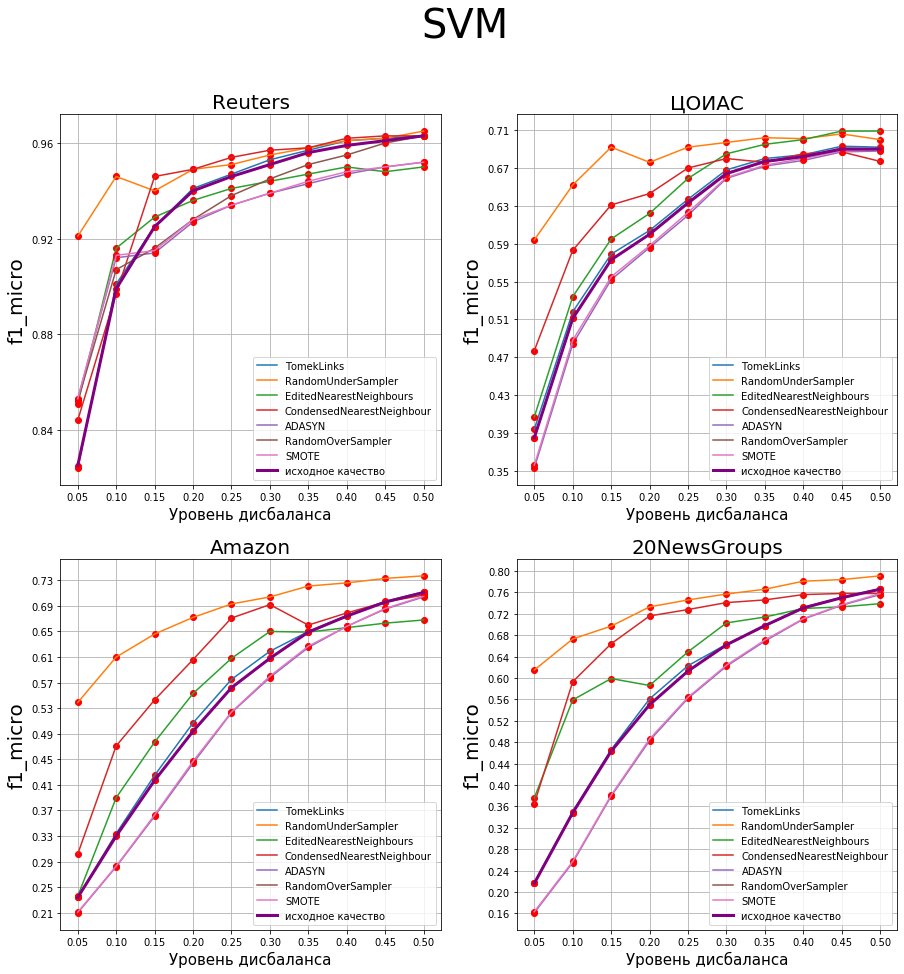

In [153]:
plot_results(svm_results, 'SVM')

In [142]:
xgb_results = all_samples_resarch(XGBClassifier, xgb_space, cv=3, evals=5)

100%|█████████████████████████████████████████████████| 5/5 [03:38<00:00, 43.67s/trial, best loss: -0.9473422620742777]
{'colsample_bylevel': 0.9, 'colsample_bytree': 0.25, 'learning_rate': 0.225, 'max_depth': 5, 'min_child_weight': 0.15, 'n_estimators': 250, 'subsample': 0.3}
0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
[[0.805 0.723 0.808 0.721 0.882 0.789 0.839 0.746 0.823 0.752 0.843 0.755
  0.853 0.77  0.842 0.756]
 [0.881 0.794 0.89  0.802 0.908 0.824 0.899 0.8   0.837 0.777 0.906 0.821
  0.906 0.824 0.904 0.82 ]
 [0.911 0.825 0.916 0.834 0.93  0.842 0.919 0.825 0.928 0.841 0.926 0.847
  0.922 0.826 0.926 0.841]
 [0.925 0.844 0.929 0.849 0.93  0.839 0.927 0.834 0.935 0.848 0.932 0.844
  0.931 0.843 0.932 0.847]
 [0.934 0.854 0.933 0.854 0.939 0.866 0.927 0.843 0.936 0.848 0.942 0.869
  0.939 0.86  0.939 0.86 ]
 [0.937 0.857 0.937 0.856 0.94  0.864 0.934 0.857 0.94  0.859 0.942 0.87
  0.942 0.869 0.944 0.872]
 [0.943 0.872 0.942 0.875 0.945 0.876 0.93

In [145]:
save_results(xgb_results, 'xgb')

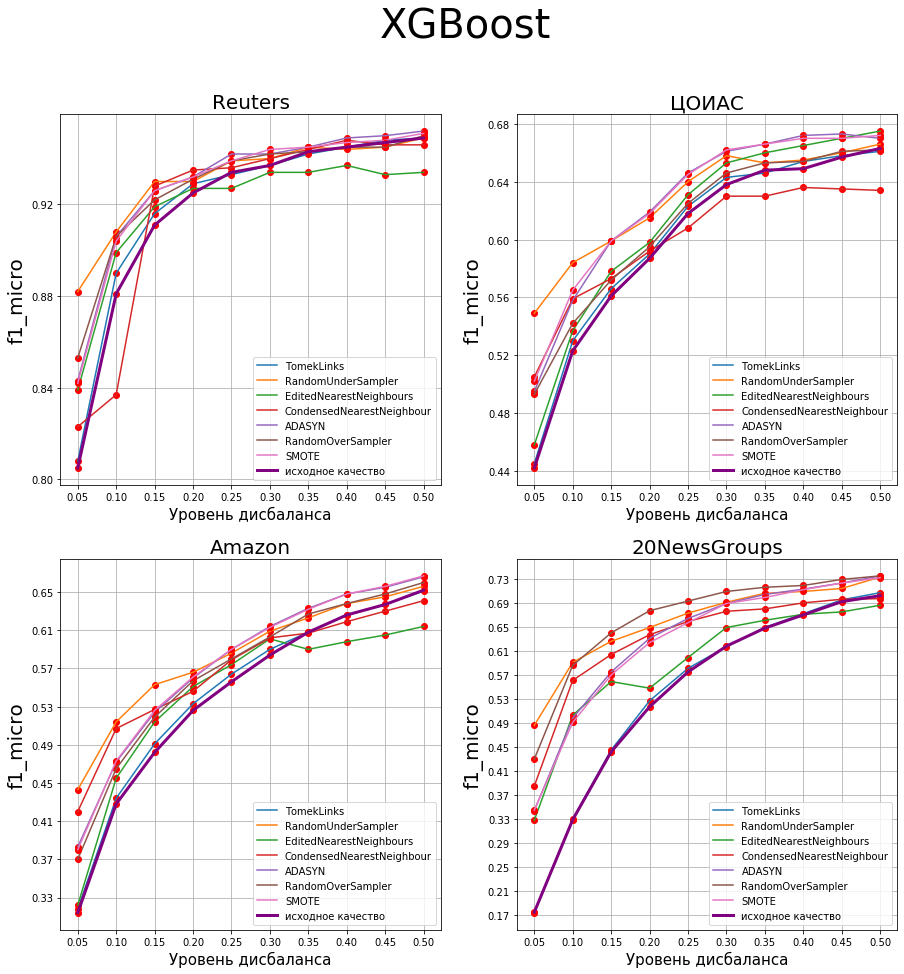

In [143]:
plot_results(xgb_results, 'XGBoost')

In [149]:
rf_results = all_samples_resarch(RandomForestClassifier, space4rf, evals=10, cv=5)

100%|████████████████████████████████████████████████| 10/10 [02:01<00:00, 12.18s/trial, best loss: -0.514421885533298]
{'criterion': 'gini', 'max_depth': 19, 'max_features': 3, 'n_estimators': 1600}
0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
[[0.201 0.075 0.201 0.073 0.906 0.821 0.26  0.124 0.384 0.318 0.699 0.553
  0.825 0.696 0.762 0.59 ]
 [0.229 0.132 0.231 0.13  0.924 0.875 0.358 0.275 0.501 0.422 0.834 0.704
  0.905 0.827 0.85  0.731]
 [0.302 0.199 0.293 0.197 0.938 0.888 0.487 0.444 0.891 0.764 0.883 0.78
  0.927 0.867 0.885 0.802]
 [0.341 0.259 0.335 0.255 0.941 0.894 0.587 0.527 0.909 0.765 0.91  0.826
  0.934 0.879 0.906 0.842]
 [0.408 0.337 0.404 0.335 0.94  0.894 0.668 0.594 0.914 0.744 0.92  0.839
  0.935 0.882 0.915 0.85 ]
 [0.493 0.421 0.499 0.423 0.937 0.89  0.72  0.635 0.908 0.731 0.927 0.856
  0.934 0.887 0.913 0.861]
 [0.566 0.496 0.565 0.5   0.939 0.89  0.765 0.676 0.898 0.72  0.933 0.865
  0.939 0.891 0.921 0.877]
 [0.621 0.556 0.626

In [150]:
save_results(rf_results, 'rf')

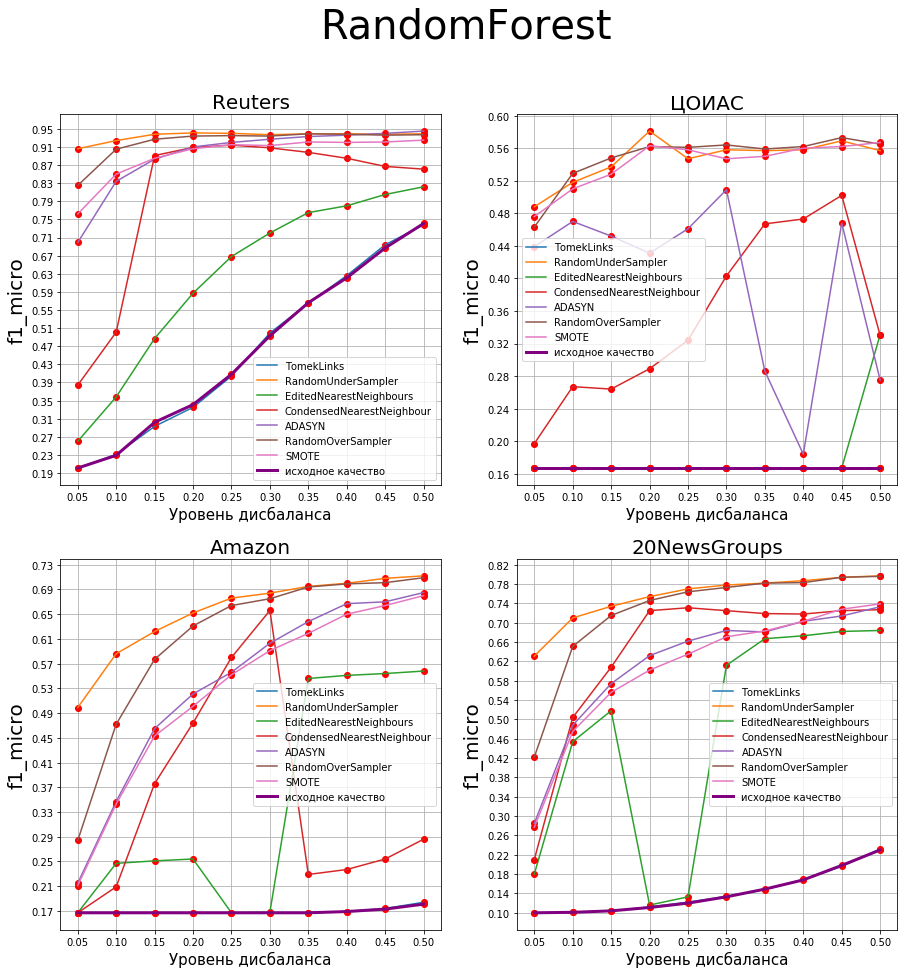

In [151]:
plot_results(rf_results, 'RandomForest')

In [146]:
log_results = all_samples_resarch(LogisticRegression, log_space, evals=10, cv=5)

100%|████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.76s/trial, best loss: -0.958266616954208]
{'C': 20, 'max_iter': 700, 'solver': 'liblinear', 'tol': 0.13385050209080032}
0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
[[0.799 0.725 0.8   0.725 0.912 0.814 0.837 0.756 0.829 0.739 0.911 0.816
  0.903 0.81  0.899 0.805]
 [0.901 0.823 0.904 0.823 0.943 0.861 0.927 0.843 0.884 0.806 0.947 0.867
  0.943 0.864 0.941 0.865]
 [0.932 0.854 0.933 0.854 0.95  0.878 0.937 0.855 0.948 0.877 0.95  0.865
  0.95  0.88  0.947 0.866]
 [0.943 0.871 0.944 0.871 0.956 0.891 0.945 0.874 0.954 0.893 0.955 0.878
  0.955 0.888 0.95  0.874]
 [0.95  0.884 0.951 0.885 0.954 0.892 0.948 0.879 0.957 0.886 0.956 0.882
  0.958 0.897 0.954 0.881]
 [0.952 0.89  0.953 0.89  0.957 0.897 0.947 0.878 0.956 0.877 0.958 0.888
  0.958 0.897 0.955 0.888]
 [0.956 0.894 0.957 0.895 0.959 0.901 0.949 0.881 0.958 0.876 0.96  0.894
  0.96  0.902 0.958 0.893]
 [0.96  0.903 0.96  

C:\Games\anaconda\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

C:\Games\anaconda\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

 50%|████████████████████████                        | 5/10 [01:56<02:33, 30.75s/trial, best loss: -0.7880446305788225]

C:\Games\anaconda\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



100%|███████████████████████████████████████████████| 10/10 [05:08<00:00, 30.86s/trial, best loss: -0.7880446305788225]
{'C': 5, 'max_iter': 700, 'solver': 'saga', 'tol': 0.05472915656842382}
0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
[[0.287 0.259 0.284 0.256 0.541 0.538 0.292 0.268 0.396 0.399 0.447 0.454
  0.444 0.451 0.447 0.453]
 [0.429 0.444 0.439 0.454 0.593 0.592 0.476 0.483 0.548 0.559 0.552 0.558
  0.552 0.559 0.549 0.558]
 [0.521 0.538 0.532 0.546 0.635 0.634 0.557 0.561 0.587 0.59  0.603 0.606
  0.601 0.603 0.604 0.608]
 [0.582 0.592 0.593 0.599 0.657 0.653 0.608 0.606 0.616 0.615 0.641 0.639
  0.634 0.632 0.64  0.639]
 [0.633 0.635 0.625 0.63  0.684 0.679 0.648 0.646 0.664 0.66  0.665 0.662
  0.661 0.656 0.671 0.667]
 [0.667 0.667 0.656 0.657 0.695 0.691 0.676 0.674 0.683 0.68  0.68  0.676
  0.678 0.674 0.68  0.677]
 [0.681 0.68  0.688 0.686 0.709 0.704 0.651 0.618 0.675 0.672 0.702 0.697
  0.696 0.691 0.705 0.701]
 [0.692 0.691 0.694 0.693 

In [147]:
save_results(log_results, 'log')

In [7]:
def write_excel(name):
    with open(f'results\\{name}.p', 'rb') as fp:
        res = pickle.load(fp)
    writer = pd.ExcelWriter(f'excel_reports\\{name}.xlsx', engine='xlsxwriter')
    workbook = writer.book

    names = ['уровень дисбаланса', 'исходное качество','TomekLinks','RUS','ENN','CNN',
     'ADASYN',
     'ROS',
     'SMOTE']
    i = 1
    for result, params in res['results']:
        micro_results = np.hstack([np.arange(0.05, 0.55, 0.05).reshape(-1, 1),result[:, range(0, result.shape[1], 2)]])
        res_df = pd.DataFrame(micro_results)
        res_df.columns = names

        res_df.to_excel(writer, sheet_name=f"Sheet{i}", index=False)
        # Get workbook

        # Get Sheet1
        worksheet = writer.sheets[f'Sheet{i}']

        cell_format = workbook.add_format()
        cell_format.set_font_name('Times New Roman')
        cell_format.set_font_size(12)
        worksheet.set_column('A:I', None, cell_format)

        header_format = workbook.add_format()
        header_format.set_font_name('Times New Roman')
        header_format.set_font_size(12)
        header_format.set_bold()
        for col_num, value in enumerate(res_df.columns.values):
            worksheet.write(0, col_num, value, header_format)
        border_fmt = workbook.add_format({'bottom':1, 'top':1, 'left':1, 'right':1})
        worksheet.conditional_format(xlsxwriter.utility.xl_range(0, 0, len(res_df), len(res_df.columns) -1), {'type': 'no_errors', 'format': border_fmt})
        i += 1
    writer.close()


In [8]:
write_excel('rf')